In [86]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
import torch

In [87]:
# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPU
if 
   exists('/dev/nvidia0'):0'):
elsexists('/dev/nvidia0'):
   exisexists('/dev/nvidia0'):

# Load and clean data

In [88]:
# Download data
legitimate_URLs = np.load("small_data/legitimate_URLs.npy")
legitimate_URLs = np.concatenate((legitimate_URLs,np.load("small_data/legitimate_URLs2.npy", allow_pickle = True)))
phishing_URLs = np.load("small_data/phishing_URLs.npy")
phishing_URLs = np.concatenate((phishing_URLs,np.load("small_data/phishing_URLs2.npy", allow_pickle = True)))

# randomly permute URLs
np.random.seed(0)
legitimate_URLs = list(legitimate_URLs[np.random.permutation(len(legitimate_URLs))])
phishing_URLs = list(phishing_URLs[np.random.permutation(len(phishing_URLs))])

# clean URLs
legitimate_URLs = [l.split('http://')[-1].split('www.')[-1].split('https://')[-1] for l in legitimate_URLs]
phishing_URLs = [p.split('http://')[-1].split('www.')[-1].split('https://')[-1] for p in phishing_URLs]
phishing_URLs = list(set(phishing_URLs) - set(legitimate_URLs))

In [89]:
len(legitimate_URLs), len(phishing_URLs)

# Legit > Phishing, molti phishing duplicati con questo dataset

(191471, 13483)

In [90]:
# map to numbers
letters = ''.join(legitimate_URLs+phishing_URLs) #String unica di URL senza spazi
from collections import Counter
c = Counter(letters) # Dizionario con occorrenze delle lettere
d = {}
for i, l in enumerate(c):
    if (i >= 128):
        break
    d[l] = i + 1 # Dizionario ordinato per numero di occorrenze
print(d)

{'b': 1, 'a': 2, 't': 3, 'u': 4, 'i': 5, 'k': 6, '.': 7, 'c': 8, 'o': 9, 'm': 10, '/': 11, 'n': 12, 'y': 13, 'h': 14, 'l': 15, 'g': 16, 'e': 17, 'r': 18, 'd': 19, 'f': 20, 's': 21, 'x': 22, '2': 23, '?': 24, 'M': 25, '=': 26, 'A': 27, 'z': 28, '-': 29, '1': 30, '4': 31, '6': 32, 'v': 33, 'j': 34, 'p': 35, '7': 36, '0': 37, 'S': 38, 'K': 39, 'E': 40, 'C': 41, 'T': 42, 'I': 43, 'N': 44, '3': 45, 'w': 46, '5': 47, '8': 48, '&': 49, ':': 50, '_': 51, 'q': 52, '9': 53, 'P': 54, 'L': 55, 'D': 56, 'F': 57, 'R': 58, '%': 59, 'G': 60, 'V': 61, 'Y': 62, 'W': 63, 'Z': 64, 'X': 65, 'Q': 66, 'H': 67, 'J': 68, 'B': 69, 'O': 70, '+': 71, 'U': 72, ',': 73, '\\': 74, 'о': 75, 'н': 76, '~': 77, '<': 78, ';': 79, '>': 80, 'С': 81, 'б': 82, 'л': 83, 'и': 84, 'м': 85, 'в': 86, 'а': 87, 'е': 88, 'װ': 89, 'ƪ': 90, '(': 91, ')': 92, "'": 93, 'к': 94, 'п': 95, 'г': 96, 'й': 97, 'Ң': 98, 'Ҫ': 99, 'ҧ': 100, '俿': 101, 'д': 102, 'ֳ': 103, 'ǹ': 104, 'ú': 105, '|': 106, 'Р': 107, 'ä': 108, 'ҵ': 109, 'ö': 110, 'ó': 1

In [91]:
# training set: all keys plus non-keys
# testing set: remaining non-keys 
training_list = legitimate_URLs[:int(len(legitimate_URLs)/2)]+phishing_URLs
testing_list = legitimate_URLs[int(len(legitimate_URLs)/2):]
    
# cut off at 150 chars
char_cutoff = 150

# Matrice con entry i vari URL del training set portati a 150 char con eventuale padding/troncatura.
# Gli URL vengono rappresentati sostiuendo ad ogni lettera l'int rappresentante la posizione nelle occorrenze
X_train = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in training_list])
y_train = torch.tensor([0]*int(len(legitimate_URLs)/2)+[1]*int(len(phishing_URLs)))

X_test = torch.tensor([[d.get(l,0) for l in url[:min([len(url),char_cutoff])]]+[0 for l in range(char_cutoff-len(url))] 
                        for url in testing_list])
y_test = torch.tensor([0]*(len(testing_list)))

X_train.size()

torch.Size([109218, 150])

In [92]:
# Batch data
def make_batch_train(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s]*torch.ones(len(X_t[s])).long() for s in sample]).to(device)     #
  batch_y = batch_y0.to(device)
  return batch_X, batch_y
  
def make_batch_test(X_t, y_t, B):
  sample = torch.randint(0, X_t.shape[0], [B]).long()
  batch_X0 = torch.stack([X_t[s] for s in sample])
  batch_X = batch_X0.to(device)
  batch_y0 = torch.stack([y_t[s] for s in sample]).to(device)
  batch_y = batch_y0.to(device)
  return batch_X, batch_y


In [93]:
class RNN(nn.Module):
    def __init__(self, input_size=150, output_size=2, emb_size=128, h_size=128, layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, h_size, num_layers=layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, output_size)
        
    def forward(self, x, h=None):
        x = self.embedding(x)
        x, h = self.rnn(x, h)
        x = self.linear(x)
        return x, h

In [94]:
def val(model, X_t, y_t):
    model.eval()
    with torch.no_grad():
        total = 0
        total_right = 0
        total_loss = 0
        for batch in range(50):
            x,y = make_batch_test(X_t, y_t, 256)
            y_hat, _ = model(x)
            #optimizer.zero_grad()
            preds = y_hat.max(dim=2)[1][:,149]
            preds_eq = preds.eq(y)
            total_right += preds_eq.sum().item()
            total += preds_eq.numel()
            loss = criterion(y_hat[:,149].view(-1,2), y.view(-1).long()).detach().item()
            total_loss += loss
    return total_right / total, total_loss / 50

In [95]:
def train(model):
    model.train()
    total_loss = 0
    for batch in range(50):
        x, y = make_batch_train(X_train, y_train, 256)
        y_hat, _ = model(x)
        optimizer.zero_grad()
        y_hat = y_hat.view(-1,2)
        y = y.view(-1).long()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    return total_loss / 50

In [96]:
emb_size=5
h_sizes = [16,8,4]
layers = 1
criterion = nn.CrossEntropyLoss()
#loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/simulations/"
loc = "trained_NN/simulations/"
#plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"
plot_loc = "/content/gdrive/My Drive/trained_NN/plots/"

# Train (don't need to run this)

In [97]:
models = {}
for i in range(3):
  h_size = h_sizes[i]
  # Create model, loss function, optimizer
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  optimizer = torch.optim.Adamax(models[i].parameters())

  # Train and validate
  start = time.time()
  for epoch in range(30):
      train_loss = train(models[i])
      val_acc, val_loss = val(models[i],X_train,y_train)
      if(epoch%10 == 0):
        print('[E{:4d}] Loss: {:.4f} | Acc: {:.4f}'.format(epoch, val_loss, val_acc))
  end = time.time()
  print(end-start)
  torch.save(models[i].state_dict(), loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))  

[E   0] Loss: 0.3744 | Acc: 0.8730
[E  10] Loss: 0.3606 | Acc: 0.8780
[E  20] Loss: 0.2896 | Acc: 0.8827
365.7287142276764
[E   0] Loss: 0.3718 | Acc: 0.8769
[E  10] Loss: 0.3677 | Acc: 0.8759
[E  20] Loss: 0.3353 | Acc: 0.8787
326.06121945381165
[E   0] Loss: 0.4572 | Acc: 0.8724
[E  10] Loss: 0.3559 | Acc: 0.8819
[E  20] Loss: 0.3704 | Acc: 0.8723
297.53235507011414


# Load trained RNNs and evaluate (change paths)

In [13]:
# sizes of RNN models
models = {}
model_sizes = {}
for i,h_size in enumerate(h_sizes):
  print("hidden size", h_size)
  model_sizes[i] = os.path.getsize(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size))
  print("model size (bytes)", model_sizes[i])
  models[i] = RNN(emb_size=emb_size, h_size=h_size, layers=layers).to(device)
  models[i].load_state_dict(torch.load(loc+"RNN_emb"+str(emb_size)+"_hid"+str(h_size)))
  models[i].eval()
  print(val(models[i], X_test,y_test))
  
  avg_time = 0
  for t in range(100):
    x,y = make_batch_test(X_test, y_test,1)
    start = time.time()
    models[i](x)
    total = time.time()-start
    avg_time += total
  avg_time /= 100
  print("time to evaluate", avg_time)
  print("="*30)

hidden size 16
model size (bytes) 10215
(0.972109375, 0.06910544820129871)
time to evaluate 0.008493258953094482
hidden size 8
model size (bytes) 7015
(0.98234375, 0.09621992483735084)
time to evaluate 0.008581926822662353
hidden size 4
model size (bytes) 6055
(0.993515625, 0.11199286326766014)
time to evaluate 0.008457319736480713


# Bloom Filter Class

In [14]:
import mmh3
import math
import torch
from bitarray import bitarray 

class BloomFilter(object): 
  
    def __init__(self, items_count,fp_prob): 
        ''' 
        items_count : int 
            Number of items expected to be stored in bloom filter 
        fp_prob : float 
            False Positive probability in decimal 
        '''
        # False posible probability in decimal 
        self.fp_prob = fp_prob 
  
        # Size of bit array to use 
        self.size = self.get_size(items_count,fp_prob) 
  
        # number of hash functions to use 
        self.hash_count = self.get_hash_count(self.size,items_count) 
  
        # Bit array of given size 
        self.bit_array = bitarray(self.size) 
  
        # initialize all bits as 0 
        self.bit_array.setall(0) 
  
    def add(self, item): 
        ''' 
        Add an item in the filter 
        '''
        digests = [] 
        for i in range(self.hash_count): 
            # i works as seed to mmh3.hash() function 
            digest = mmh3.hash(item,i) % self.size 
            digests.append(digest) 
  
            # set the bit True in bit_array 
            self.bit_array[digest] = True
  
    def check(self, item): 
        ''' 
        Check for existence of an item in filter 
        '''
        for i in range(self.hash_count): 
            digest = mmh3.hash(item,i) % self.size 
            if self.bit_array[digest] == False: 
  
                # if any of bit is False then,its not present 
                # in filter 
                # else there is probability that it exist 
                return False
        return True
  
    @classmethod
    def get_size(self,n,p): 
        ''' 
        Return the size of bit array(m) to used using 
        following formula 
        m = -(n * lg(p)) / (lg(2)^2) 
        n : int 
            number of items expected to be stored in filter 
        p : float 
            False Positive probability in decimal 
        '''
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m) 
  
    @classmethod
    def get_hash_count(self, m, n): 
        ''' 
        Return the hash function(k) to be used using 
        following formula 
        k = (m/n) * lg(2) 
  
        m : int 
            size of bit array 
        n : int 
            number of items expected to be stored in filter 
        '''

        k = (m/n) * math.log(2) 
        return int(k)

# BF

In [15]:
def run_BF(FPR):
  # Crea BF su un set di Key pari al numero di phishing e con target FPR
  BF = BloomFilter(len(phishing_URLs), FPR)
  for url in phishing_URLs:
    BF.add(url)
  
  
  fps = 0
  total = 0
  total_time = 0
  # Testa il filtro di bloom su l'insieme dei legit per calcolare il tasso di FPR
  for url in testing_list:
    total += 1
    start = time.time()
    result = BF.check(url)
    end = time.time()
    total_time += (end-start)
    # Se elemento presente allora falso positivo
    if result == True:
      fps += 1
  
  avg_fp = fps/total

  # returns empirical FPR, BF size in bytes, and access time per element
  return avg_fp, BF.size/8, (total_time)/len(testing_list)

In [16]:
FPR, BF_size, t = run_BF(0.02)
print("FPR", FPR, "size", BF_size, "time", t)
BF = {"FPR": FPR, "size": BF_size, "time": t}
np.save(loc+"BF", BF)

FPR 0.02482869557951032 size 13722.875 time 1.0709784687775722e-06


In [17]:
BF_sizes = {}
# Aggiungo alcuni fpr
fprs = [0.001,0.005,0.01,0.02]
# Stampa grandezza del filtro in relazione al target fpr
for fpr in fprs:
  BF = BloomFilter(len(phishing_URLs), fpr)
  BF_sizes[fpr] = BF.size / 8
  
print(BF_sizes)

{0.001: 24231.625, 0.005: 18585.875, 0.01: 16154.375, 0.02: 13722.875}


# Classifier

In [18]:
# Esegue modello in input precedentemente addestrato suddividendo i risultati in due liste 
# probs1 contiene risultati per le entry phishing
# probs0 contiene risultati per le entru legit
def get_classifier_probs(model):
    probs1 = []
    probs0 = []
    # Divisione in batch da 100
    for i in range(int(len(y_train)/100)+1):
        x0 = torch.stack([X_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
        x = x0.to(device)
        y0 = torch.stack([y_train[s] for s in range(100*i, min(100*(i+1), len(y_train)))])
        y = y0.to(device)  
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149]
        # Squeeze causa errori con conversione in lista se fatto con tensor di dimensione 1
        probs1 += list(ps[y==1].squeeze().detach().cpu().numpy()) 
        probs0 += list(ps[y==0].squeeze().detach().cpu().numpy())
    return probs1, probs0

In [17]:
# Grafici precedentemente commentati, non molto significativi?
probs = {}
urls = {}
probs[0] = get_classifier_probs(models[0])
probs[1] = get_classifier_probs(models[1])
probs[2] = get_classifier_probs(models[2])

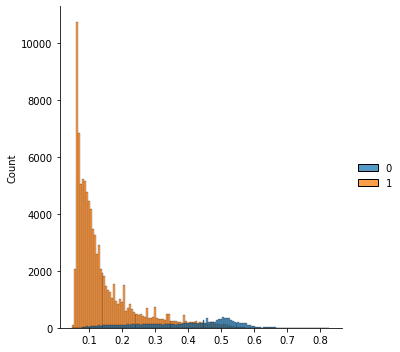

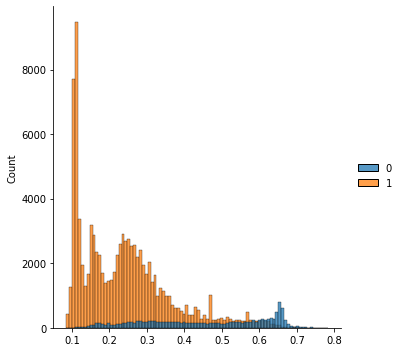

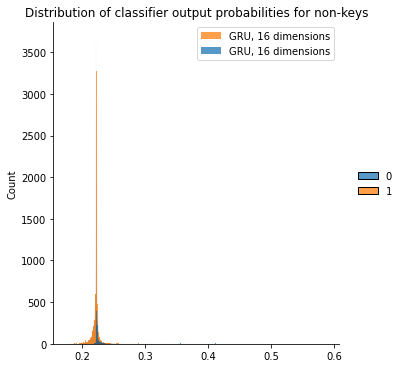

In [18]:
sns.displot(probs[0], label = "GRU, 16 dimensions") #initial experiment with 128,32,16 dimensions gru, now 16,8,4
sns.displot(probs[1], label = "GRU, 8 dimensions")
sns.displot(probs[2], label = "GRU, 4 dimensions")
plt.title("Distribution of classifier output probabilities for non-keys")
plt.legend()
plt.show()

In [20]:
def determine_tau(FPR_tau, prob_list):
  return np.percentile(np.array(prob_list),100*(1.-FPR_tau))

# LBF

In [21]:
# Costruisce classificatore per LBF e ritorna relativo numero di falsi negativi e tau ottimale
def build_LBF_classifier(model,FPR_tau):
  probs1, probs0 = get_classifier_probs(model)
  tau = determine_tau(FPR_tau,probs0)
  false_negs = []
  for i,url in enumerate(phishing_URLs):
    if(probs1[i] < tau):
      false_negs += [url]
  return false_negs, tau

In [22]:
def build_LBF_backup(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = (FPR-FPR_tau)/(1-FPR_tau)
  if(FPR_B <= 0):
    return "error"
  LBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    LBF_backup.add(url)
  return LBF_backup

In [35]:
def test_LBF(model, LBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    # Aggiunto if per evitare eccezioni da stack se la lista é vuota
    if(len([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))]) > 0):
        x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        x = x0.to(device)
        y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        y = y0.to(device)  
        total += len(y)

        start = time.time()
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
        for ix, p in enumerate(ps):
          if(p > tau):
            result = True        
          else:
            result = LBF_backup.check(testing_list[100*i+ix])
          if(result):
            fps += 1
        end = time.time()
        total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, LBF_backup.size / 8, (total_time)/len(y_test)

# SBF.py equivalent

In [24]:
def build_SLBF_initial(false_negs, FPR, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B0 = FPR/FPR_tau*(1.-num_false_negs/len(phishing_URLs))
  if(FPR_B0 <= 0 or FPR_B0 >= 1):
    return "error"
  SLBF_initial = BloomFilter(len(phishing_URLs), FPR_B0)
  for url in phishing_URLs:
    SLBF_initial.add(url)
  return SLBF_initial

In [25]:
def build_SLBF_backup(false_negs, FPR_tau):
  num_false_negs = len(false_negs)
  FPR_B = FPR_tau/((1-FPR_tau)*(len(phishing_URLs)/num_false_negs - 1))
  if(FPR_B <= 0):
    return "error"
  SLBF_backup = BloomFilter(num_false_negs, FPR_B)
  for url in false_negs:
    SLBF_backup.add(url)
  return SLBF_backup

In [34]:
def test_SLBF(SLBF_initial, model, SLBF_backup, tau):
  # test on testing data
  fps = 0
  total = 0
  total_time = 0
  for i in range(int(len(y_test)/100)+1):
    # Aggiunto if per evitare eccezioni da stack se la lista é vuota
    if(len([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))]) > 0):
        x0 = torch.stack([X_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        x = x0.to(device)
        y0 = torch.stack([y_test[s] for s in range(100*i, min(100*(i+1), len(y_test)))])
        y = y0.to(device)  
        total += len(y)

        start = time.time()
        y_hat, _ = model(x)
        ps = torch.sigmoid(y_hat[:,:,1])[:,149].squeeze().detach().cpu().numpy()
        for ix, p in enumerate(ps):
          result = SLBF_initial.check(testing_list[100*i+ix])
          if(result):
            if(p>tau):
              result = True
            else:
              result = SLBF_backup.check(testing_list[100*i+ix])
          if(result):
            fps += 1
        end = time.time()
        total_time += (end-start)

  avg_fp = fps/total
  
  # returns empirical FPR, BF size, and avg access time
  return avg_fp, (SLBF_initial.size+SLBF_backup.size) / 8, (total_time)/len(y_test)

# $\tau$ analysis for LBF

In [27]:
fprs = [0.001,0.005,0.01,0.02]
fpr_ratios = [0.1*i for i in range(1,11)] # Ma fpr ratio 1.0 non ha senso?
false_negs = {}
taus = {}

# Per ognuno dei modelli salvo numero di falsi negativi del classificatore e tau ottimale nelle relative strutture sulla
# base del fprs e fpr_ratio target.
for i in range(3):
  false_negs[i] = {}
  taus[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      # Cambiata print
      print("Modello %d: %.3f, %.2f, %.20f, %.10f" % (i, fpr, fpr_ratio, len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)]))
      # print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

Modello 0: 0.001, 0.10, 0.98427649632871028196, 0.6217659331
Modello 0: 0.001, 0.20, 0.97863976859749313153, 0.6047242920
Modello 0: 0.001, 0.30, 0.97367054809760433809, 0.5987122773
Modello 0: 0.001, 0.40, 0.96247126010531780516, 0.5849396987
Modello 0: 0.001, 0.50, 0.95097530223244086667, 0.5767970431
Modello 0: 0.001, 0.60, 0.94029518653118737692, 0.5717914356
Modello 0: 0.001, 0.70, 0.93458429132982279164, 0.5688798815
Modello 0: 0.001, 0.80, 0.92664837202403027572, 0.5646937487
Modello 0: 0.001, 0.90, 0.92138248164355118774, 0.5623712817
Modello 0: 0.001, 1.00, 0.91470740933026772890, 0.5592504740
Modello 0: 0.005, 0.10, 0.95097530223244086667, 0.5767970431
Modello 0: 0.005, 0.20, 0.91470740933026772890, 0.5592504740
Modello 0: 0.005, 0.30, 0.89127048876362824359, 0.5494798721
Modello 0: 0.005, 0.40, 0.87065193206259738901, 0.5407956624
Modello 0: 0.005, 0.50, 0.85559593562263591693, 0.5354633614
Modello 0: 0.005, 0.60, 0.83964992954090333921, 0.5303893454
Modello 0: 0.005, 0.70, 

In [1]:
# Salva risultati della cella precedente, ma poi li usa?
np.save(loc+"false_negs", false_negs)
np.save(loc+"taus", taus)

NameError: name 'np' is not defined

In [36]:
LBF_backups = {}

# Per ognuno dei modelli salvo il filtro di backup costruito sulla base del fpr e fpr_ratio target
for i in range(3):
  LBF_backups[i] = {}
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      #try:
        LBF_backups[i][(fpr,fpr_ratio)] = build_LBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
        if(LBF_backups[i][(fpr,fpr_ratio)] =='error'):
          print("bad epsilon")
          continue
        fpr0, BF_size, t = test_LBF(models[i], LBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
        print(fpr, fpr0, BF_size, t)
        LBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
        np.save(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), LBF)
      #except:
        # Se il numero di falsi negativi é 0 sollevo eccezione e non salvo
        # Non controllata inizialmente probabilbente perché é stata esclusa la possibilitá di avere fn = 0 con dataset grandi
      #  print("Numero falsi negativi = 0")

0.001 0.001305673936659146 24214.0 0.00022136003309456917
0.001 0.0008774128854349461 24479.375 0.00020248192169716695
0.001 0.0010132029748474974 24810.75 0.0002290928753294761
0.001 0.001117656889780229 25045.5 0.00024832736442708086
0.001 0.0009714214088744046 25354.25 0.00021780905662208927
0.001 0.0009714214088744046 25805.125 0.0002273980628042539
0.001 0.001128102281273502 26591.25 0.00022357105810341205
0.001 0.0009714214088744046 27683.125 0.00024407123317991052
0.001 0.0010236483663407705 29765.875 0.0002507173801869032
bad epsilon
0.005 0.005107796440210579 18024.5 0.0002239540479551175
0.005 0.004940670176318209 17713.375 0.00022515979308855707
0.005 0.004679535388986379 17675.5 0.00022631633587525863
0.005 0.004857107044372023 17735.75 0.00022200691806569756
0.005 0.0053167042700760425 17974.75 0.00022534076617835327
0.005 0.005066014874237487 18295.625 0.00022641099006338528
0.005 0.005410712793515501 18838.75 0.00022776618262445797
0.005 0.005055569482744213 19696.625 0.

In [37]:
fnrs = {}
# Per ognuno dei modelli costruisco un dataframe in cui salvo il rate di falsi negativi per ogni fpr e fprs_ratio
for i in range(3):
  fnrs[i] = pd.DataFrame(index=fpr_ratios, columns=fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      fnrs[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [38]:
true_fpr_LBF = {}
sizes_LBF = {}
times_LBF = {}
# Per ogni modello salvo in base a fpr, fpr_ratio target l'frp empirico, la grandezza ed il tempo di accesso per elemento
# del LBF relativa
# Utile per i grafici successivi
for i in range(3):
  true_fpr_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
        true_fpr_LBF[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        # Aggiunta except utile nel caso in cui il file non fosse stato salvato perché fn = 0
        print("error / numero falsi negativi 0")
        continue

0.001305673936659146 34436.0 0.00022136003309456917
0.0008774128854349461 34701.375 0.00020248192169716695
0.0010132029748474974 35032.75 0.0002290928753294761
0.001117656889780229 35267.5 0.00024832736442708086
0.0009714214088744046 35576.25 0.00021780905662208927
0.0009714214088744046 36027.125 0.0002273980628042539
0.001128102281273502 36813.25 0.00022357105810341205
0.0009714214088744046 37905.125 0.00024407123317991052
0.0010236483663407705 39987.875 0.0002507173801869032
error / numero falsi negativi 0
0.005107796440210579 28246.5 0.0002239540479551175
0.004940670176318209 27935.375 0.00022515979308855707
0.004679535388986379 27897.5 0.00022631633587525863
0.004857107044372023 27957.75 0.00022200691806569756
0.0053167042700760425 28196.75 0.00022534076617835327
0.005066014874237487 28517.625 0.00022641099006338528
0.005410712793515501 29060.75 0.00022776618262445797
0.005055569482744213 29918.625 0.00022837265876437862
0.005201804963650037 31537.0 0.0002306516959253405
error / nu

In [39]:
#plot_loc = "/content/gdrive/My Drive/College/current classes/CS 222 fall 2018/CS222 Project/plots/"
plot_loc = "trained_NN/plots/"

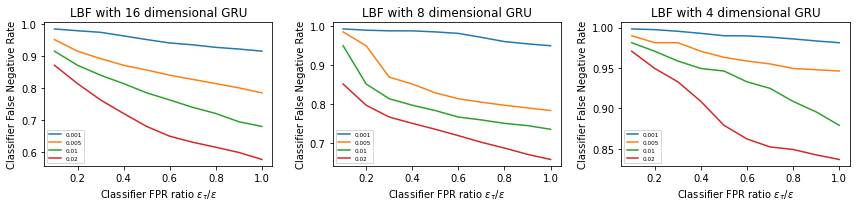

In [40]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_classifier_FNR.png")
# FPR_tau/FPR forced to stay between 0 and 1, 

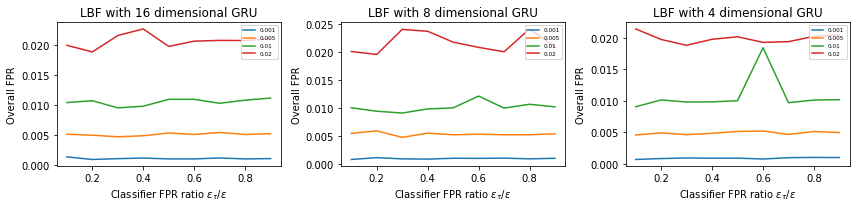

In [41]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper right')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_fpr.png")
#regardless of what the desired FPR is, the curve looks the same??

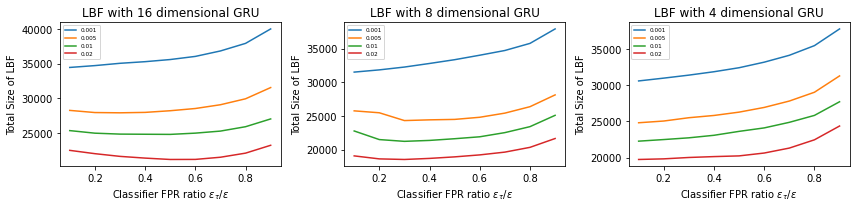

In [42]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_LBF[i].plot(ax=ax[i])
  ax[i].set_xlabel("Classifier FPR ratio "+r"$\epsilon_\tau/\epsilon$")
  ax[i].set_ylabel("Total Size of LBF")
  ax[i].set_title("LBF with "+str(h_sizes[i])+" dimensional GRU")
  ax[i].legend(fontsize='xx-small', loc='upper left')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"LBF_size.png")
# seems most optimal at 0.5

# $\tau$ analysis for SLBF

In [43]:
fpr_ratios2 = [1.*i for i in range(1,11)]

# Per ognuno dei modelli salvo numero di falsi negativi del classificatore e tau ottimale nelle relative strutture sulla
# base del fprs e fpr_ratio target.
for i in range(3):
  for fpr in fprs:
    for fpr_ratio in fpr_ratios2:
      false_negs[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)] = build_LBF_classifier(models[i], fpr*fpr_ratio)
      print("Modello %d: %.3f, %.2f, %.20f, %.10f" % (i, fpr, fpr_ratio, len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)]))
      # print(len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs), taus[i][(fpr,fpr_ratio)])

Modello 0: 0.001, 1.00, 0.91470740933026772890, 0.5592504740
Modello 0: 0.001, 2.00, 0.87065193206259738901, 0.5407956624
Modello 0: 0.001, 3.00, 0.83964992954090333921, 0.5303893454
Modello 0: 0.001, 4.00, 0.81332047763850778832, 0.5235099702
Modello 0: 0.001, 5.00, 0.78439516428094635536, 0.5172455090
Modello 0: 0.001, 6.00, 0.76214492323666838125, 0.5124505594
Modello 0: 0.001, 7.00, 0.73900467255061930150, 0.5070175529
Modello 0: 0.001, 8.00, 0.71979529778239259574, 0.5029870234
Modello 0: 0.001, 9.00, 0.69398501817103019906, 0.4972358277
Modello 0: 0.001, 10.00, 0.67929985908180667842, 0.4928513610
Modello 0: 0.005, 1.00, 0.78439516428094635536, 0.5172455090
Modello 0: 0.005, 2.00, 0.67929985908180667842, 0.4928513610
Modello 0: 0.005, 3.00, 0.62367425647111174314, 0.4745519757
Modello 0: 0.005, 4.00, 0.57598457316620932378, 0.4584189188
Modello 0: 0.005, 5.00, 0.52480901876436991671, 0.4420215473
Modello 0: 0.005, 6.00, 0.49336201142179042511, 0.4267855650
Modello 0: 0.005, 7.00,

In [44]:
np.save(loc+"false_negs2", false_negs)
np.save(loc+"taus2", taus)

In [45]:
SLBF_initials = {}
SLBF_backups = {}

# Per ognuno dei modelli salvo il filtro di backup e quello iniziale costruito sulla base del fpr e fpr_ratio target
for i in range(3):
  SLBF_initials[i] = {}
  SLBF_backups[i] = {}
  for fpr, fpr_ratio in false_negs[i].keys():
    c=(1.-len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs))
    # Se la tau non rispetta i bound
    if(fpr_ratio < c or fpr*fpr_ratio > c):
      print(fpr_ratio, fpr, "bad fpr_tau")
      continue
    # try:
    SLBF_initials[i][(fpr,fpr_ratio)] = build_SLBF_initial(false_negs[i][(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
    SLBF_backups[i][(fpr,fpr_ratio)] = build_SLBF_backup(false_negs[i][(fpr,fpr_ratio)], fpr*fpr_ratio)
    if(SLBF_backups[i][(fpr,fpr_ratio)] =='error' or SLBF_initials[i][(fpr,fpr_ratio)]=='error'):
        continue
    fpr0, BF_size, t = test_SLBF(SLBF_initials[i][(fpr,fpr_ratio)], models[i], SLBF_backups[i][(fpr,fpr_ratio)], taus[i][(fpr,fpr_ratio)])
    print(fpr, fpr0, BF_size, t)
    SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[i], "time": t}
    np.save(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)
    # except:
      # Eccezione aggiunta per fn =0
      # print("Numero di falsi negativi = 0")

# for fpr, fpr_ratio in false_negs2.keys():
#   c=(1.-len(false_negs2[(fpr,fpr_ratio)])/len(phishing_URLs))
#   if(fpr_ratio < c or fpr*fpr_ratio > c):
#     print(fpr_ratio, fpr, "bad fpr_tau")
#     continue
#   SLBF_keys += [(fpr,fpr_ratio)]
#   SLBF_initials[(fpr,fpr_ratio)] = build_SLBF_initial(false_negs2[(fpr,fpr_ratio)], fpr, fpr*fpr_ratio)
#   SLBF_backups[(fpr,fpr_ratio)] = build_SLBF_backup(false_negs2[(fpr,fpr_ratio)], fpr*fpr_ratio)
#   if(SLBF_backups[(fpr,fpr_ratio)] =='error' or SLBF_initials[(fpr,fpr_ratio)]=='error'):
#     continue
#   fpr0, BF_size, t = test_SLBF(SLBF_initials[(fpr,fpr_ratio)], models[2], SLBF_backups[(fpr,fpr_ratio)], taus[(fpr,fpr_ratio)])
#   print(fpr, fpr0, BF_size, t)
#   SLBF = {"FPR": fpr0, "size": BF_size+model_sizes[2], "time": t}
#   np.save(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio), SLBF)

0.001 0.0008565221024483998 24007.0 0.00018267044748510446
0.001 0.0009400852343945851 23955.0 0.00018074849031020736
0.001 0.0013370101111389655 23908.375 0.0001812102158704955
0.001 0.0008878582769282192 23761.5 0.0001825054700764895
0.001 0.0012116654132196874 23609.0 0.0001820979500271139
0.001 0.0009400852343945851 23469.125 0.00018219518424415285
0.001 0.00105498454082059 23409.75 0.00018339808038813713
0.001 0.0008565221024483998 23313.875 0.00018284673119802627
0.001 0.0009818668003676778 23260.5 0.0001829431236681807
0.001 0.0008565221024483998 23184.125 0.00018260805860063412
0.005 0.004606417648533467 17963.25 0.0001880984223854216
0.005 0.00441840060165455 17538.375 0.00016965278459888278
0.005 0.00527492270410295 17307.25 0.00017942049015810528
0.005 0.005034678699757667 17111.0 0.00020749076890837852
0.005 0.005191359572156764 16991.625 0.000203836947403088
0.005 0.006215007938497535 16853.75 0.00019028369940302472
0.005 0.005358485836049135 16750.5 0.0001788424416533526


In [46]:
fnrs2 = {}
# Per ognuno dei modelli costruisco un dataframe in cui salvo il rate di falsi negativi per ogni fpr e fprs_ratio
for i in range(3):
  fnrs2[i] = pd.DataFrame(index=fpr_ratios+fpr_ratios2, columns=fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
      fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs[i][(fpr,fpr_ratio)])/len(phishing_URLs)
  # for fpr,fpr_ratio in false_negs2.keys():
      # fnrs2[i].loc[fpr_ratio,fpr] = len(false_negs2[i][(fpr,fpr_ratio)])/len(phishing_URLs)

In [47]:
true_fpr_SLBF = {}
sizes_SLBF = {}
times_SLBF = {}

# Per ogni modello salvo in base a fpr, fpr_ratio target l'frp empirico, la grandezza ed il tempo di accesso per elemento
# del SLBF relativo
# Utile per i grafici successivi
for i in range(3):
  true_fpr_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  sizes_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  times_SLBF[i] = pd.DataFrame(index = fpr_ratios+fpr_ratios2, columns = fprs)
  for fpr,fpr_ratio in false_negs[i].keys():
    try:
      SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
      true_fpr_SLBF[i].loc[fpr_ratio,fpr] = SLBF['FPR']
      sizes_SLBF[i].loc[fpr_ratio,fpr] = SLBF['size']
      times_SLBF[i].loc[fpr_ratio,fpr] = SLBF['time']
      print(SLBF['FPR'], SLBF['size'], SLBF['time'])
    except:
      print("error", fpr_ratio, fpr) # Bad tau + false negs = 0
      continue

# for fpr,fpr_ratio in false_negs2.keys():
#   try:
#     SLBF = np.load(loc+"SLBF_hid"+str(h_sizes[2])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy").item()
#     true_fpr_SLBF.loc[fpr_ratio,fpr] = SLBF['FPR']
#     sizes_SLBF.loc[fpr_ratio,fpr] = SLBF['size']
#     times_SLBF.loc[fpr_ratio,fpr] = SLBF['time']
#     print(SLBF['FPR'], SLBF['size'], SLBF['time'])
#   except:
#     print("error")
#     continue

0.0008565221024483998 34229.0 0.00018267044748510446
0.0009400852343945851 34177.0 0.00018074849031020736
0.0013370101111389655 34130.375 0.0001812102158704955
0.0008878582769282192 33983.5 0.0001825054700764895
0.0012116654132196874 33831.0 0.0001820979500271139
0.0009400852343945851 33691.125 0.00018219518424415285
0.00105498454082059 33631.75 0.00018339808038813713
0.0008565221024483998 33535.875 0.00018284673119802627
0.0009818668003676778 33482.5 0.0001829431236681807
0.0008565221024483998 33406.125 0.00018260805860063412
0.004606417648533467 28185.25 0.0001880984223854216
0.00441840060165455 27760.375 0.00016965278459888278
0.00527492270410295 27529.25 0.00017942049015810528
0.005034678699757667 27333.0 0.00020749076890837852
0.005191359572156764 27213.625 0.000203836947403088
0.006215007938497535 27075.75 0.00019028369940302472
0.005358485836049135 26972.5 0.0001788424416533526
0.004940670176318209 26869.125 0.00018970149197135742
0.005389822010528954 26757.875 0.000181301963790

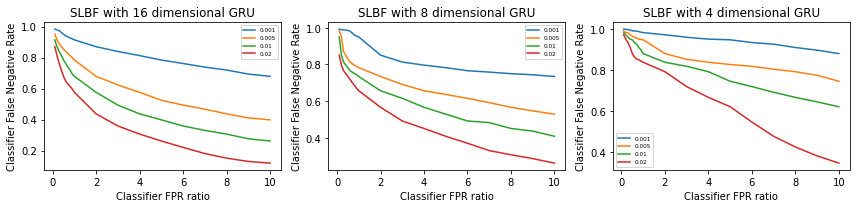

In [48]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  fnrs2[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Classifier False Negative Rate")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_classifier_FNR.png")

# FPR_tau/FPR forced to stay between 0 and 1, 

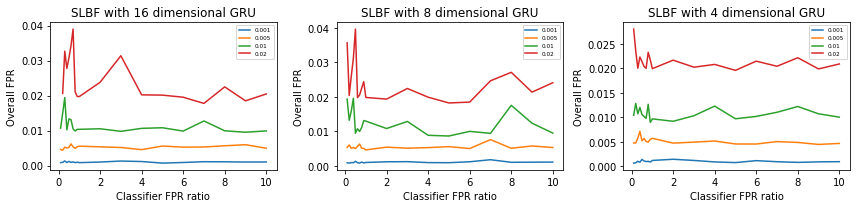

In [49]:
f,ax=plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  true_fpr_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Overall FPR")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_fpr.png")


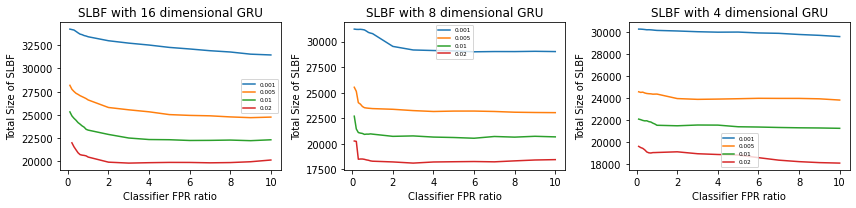

In [51]:
f, ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  sizes_SLBF[i].plot(ax=ax[i])
  ax[i].legend(fontsize='xx-small')
  ax[i].set_xlabel("Classifier FPR ratio")
  ax[i].set_ylabel("Total Size of SLBF")
  ax[i].set_title("SLBF with "+str(h_sizes[i])+" dimensional GRU")
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"SLBF_size.png")


#size is best when ratio = 1

In [50]:
true_fpr_LBF_LH = {}
sizes_LBF_LH = {}
times_LBF_LH = {}
for i in range(3):
  true_fpr_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  sizes_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  times_LBF_LH[i] = pd.DataFrame(index = fpr_ratios, columns = fprs)
  for fpr in fprs:
    for fpr_ratio in fpr_ratios:
      try:
        LBF = np.load(loc+"LBF_LH_hid"+str(h_sizes[i])+"_FPR"+str(fpr)+"_ratio"+str(fpr_ratio)+".npy", allow_pickle=True).item()
        true_fpr_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['FPR']
        sizes_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['size']
        times_LBF_LH[i].loc[fpr_ratio,fpr] = LBF['time']
        print(LBF['FPR'], LBF['size'], LBF['time'])
      except:
        print("error")
        continue


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


In [52]:
# Grafici attualmente non funzionanti, da sistemare

x_BF = []
y_BF = []
for b in BF_sizes.keys():
  x_BF += [b]
  y_BF += [BF_sizes[b]]

In [53]:
f,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(3):
  x_LBF = []
  y_LBF = []
  z_LBF = []
  x_SLBF = []
  y_SLBF = []
  z_SLBF = []
  for j1 in range(true_fpr_LBF[i].shape[1]):
    for j0 in range(true_fpr_LBF[i].shape[0]):
      x_LBF += [true_fpr_LBF[i].iloc[j0,j1]]
      y_LBF += [sizes_LBF[i].iloc[j0,j1]]
    z_LBF += [min(sizes_LBF[i].iloc[:,j1])]
  
  for j1 in range(true_fpr_SLBF[i].shape[1]):
    for j0 in range(true_fpr_SLBF[i].shape[0]):
      if sizes_SLBF[i].dropna().iloc[:,j1].size != 0:
        if(true_fpr_SLBF[i].index[j0] >= 1.):
          x_SLBF += [true_fpr_SLBF[i].iloc[j0,j1]]
          y_SLBF += [sizes_SLBF[i].iloc[j0,j1]]
        z_SLBF += [min(sizes_SLBF[i].dropna().iloc[:,j1])]
        
  ax[i].scatter(x_LBF,y_LBF, label = 'LBF', marker='.')
  ax[i].scatter(x_SLBF,y_SLBF, label = 'SLBF', marker='.')
  ax[i].plot(true_fpr_LBF[i].columns,z_LBF)
  ax[i].plot(true_fpr_SLBF[i].columns,z_SLBF)
  ax[i].set_title(str(h_sizes[i])+" dimensional GRU")
  ax[i].set_xlabel("Observed FPR")
  ax[i].set_ylabel("Total Size (bytes)")
  ax[i].set_xlim(left=0, right=0.03)
  ax[i].legend(fontsize='xx-small')
plt.tight_layout()
plt.show()
f.savefig(plot_loc+"comparison_size_min.png")

ValueError: x and y must have same first dimension, but have shapes (4,) and (80,)